# Software Design 2025/03

## 総務省統計局の「品目別都道府県庁所在市及び政令指定都市ランキング」を分析・可視化するコード例

In [2]:
dic_pre2cap={ # 県名→県庁所在地 辞書
'北海道':'札幌市',
'青森県':'青森市',
'岩手県':'盛岡市',
'宮城県':'仙台市',
'秋田県':'秋田市',
'山形県':'山形市',
'福島県':'福島市',
'茨城県':'水戸市',
'栃木県':'宇都宮市',
'群馬県':'前橋市',
'埼玉県':'さいたま市',
'千葉県':'千葉市',
'東京都':'東京都区部',
'神奈川県':'横浜市',
'新潟県':'新潟市',
'富山県':'富山市',
'石川県':'金沢市',
'福井県':'福井市',
'山梨県':'甲府市',
'長野県':'長野市',
'岐阜県':'岐阜市',
'静岡県':'静岡市',
'愛知県':'名古屋市',
'三重県':'津市',
'滋賀県':'大津市',
'京都府':'京都市',
'大阪府':'大阪市',
'兵庫県':'神戸市',
'奈良県':'奈良市',
'和歌山県':'和歌山市',
'鳥取県':'鳥取市',
'島根県':'松江市',
'岡山県':'岡山市',
'広島県':'広島市',
'山口県':'山口市',
'徳島県':'徳島市',
'香川県':'高松市',
'愛媛県':'松山市',
'高知県':'高知市',
'福岡県':'福岡市',
'佐賀県':'佐賀市',
'長崎県':'長崎市',
'熊本県':'熊本市',
'大分県':'大分市',
'宮崎県':'宮崎市',
'鹿児島県':'鹿児島市',
'沖縄県':'那覇市'}
# 県庁所在地→県名　辞書も用意する
dic_cap2pre={v:k for k,v in dic_pre2cap.items()}

### 総務省統計局の[家計調査（二人以上の世帯）　品目別都道府県庁所在市及び政令指定都市ランキング](https://www.stat.go.jp/data/kakei/5.html)のXLSXファイルを読み込む関数

In [3]:
import pandas as pd
from openpyxl import load_workbook # conda install anaconda::openpyxl

# xlsxファイルをPandas seriesとして読み込む
def append_df_from_xlsx(filepath,sheet_name,data):# .xlsxファイルを読む 
    workbook=load_workbook(filename=filepath,read_only=True)
    sheet=workbook[sheet_name]
    # 列(column)方向に処理を行う、列(column)も、行(row)も1スタート
    column=2 # 列(column)方向の読み出し開始位置(1行目はindex)
    row=3    # 品名が記載されている行(row)、次の行が数量 or 金額
    # 3行目の品名がある限り、読み込み処理を行う(列方向ループ)
    while sheet.cell(column=column,row=row).value is not None:
        name=sheet.cell(column=column,row=row).value # 品名
        print(name)
        i=5 # 5行目から読み込みを始める（5行目は全国、6行目からが都市ランキング）
        city=sheet.cell(column=column,row=i).value # 都市名
        cat=sheet.cell(column=column, row=row+1).value # 数量 or 金額
        if '金' in cat:
            category='金額'
        elif '量' in cat:
            category='数量'
        else:
            break
        if not name in data[category]: # 品名に対する辞書が未作成なら作る
            data[category][name]={}
        dic_for_series={} # seriesに変換するための辞書
        while city is not None: # 記載がある限り、上から下に、読み込みを続ける
            city=sheet.cell(column=column,row=i).value
            value=sheet.cell(column=column+1,row=i).value
            if city in dic_cap2pre: # 県庁所在地ならデータ追加
                dic_for_series[dic_cap2pre[city]]=value
            i=i+1
        data[category][name]=pd.Series(dic_for_series)
        column+=2  # 都市名、値の2行が1セット
    return data

#### 記事に掲載する「コード解説用」（実行する必要はありません）

In [ ]:
import pandas as pd;from openpyxl import load_workbook

def append_df_from_xlsx(filepath,sheet_name,data):# xlsxファイルを読む 
    workbook=load_workbook(filename=filepath,read_only=True)
    sheet=workbook[sheet_name];column=2;row=3
    while sheet.cell(column=column,row=row).value is not None:
        name=sheet.cell(column=column,row=row).value # 品名
        i=5 # 5行目から読み込み開始（5行目は全国、6行目からが都市ランキング）
        city=sheet.cell(column=column,row=i).value # 都市名
        cat=sheet.cell(column=column, row=row+1).value # 数量 or 金額
        if '金' in cat:
            category='金額'
        elif '量' in cat:
            category='数量'
        else:
            break
        if not name in data[category]: # 品名に対する辞書が未作成なら作る
            data[category][name]={}
        dic_for_series={} # seriesに変換するための辞書
        while city is not None: # 記載ある限り、上から下に読み込みを続ける
            city=sheet.cell(column=column,row=i).value
            value=sheet.cell(column=column+1,row=i).value
            if city in dic_cap2pre: # 県庁所在地ならデータ追加
                dic_for_series[dic_cap2pre[city]]=value
            i=i+1
        data[category][name]=pd.Series(dic_for_series)
        column+=2  # 都市名、値の2行が1セット
    return data

### PandasSeriesから県別色地図を描く関数

In [4]:
# 県別地図を描く
import numpy as np
import matplotlib.pyplot as plt
from japanmap import picture # OpenCVとの兼ね合いから、gamut_py37 環境に入れた

# matplotlibの日本語処理用
#plt.rcParams['font.family']='Hiragino Sans'# フォント設定
#plt.rcParams['font.weight']='bold' # 太さ
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['font.size'] = 20
plt.rcParams["figure.figsize"]=15,15

def draw_map_from_series(series,title,cmap,min_max=False):
    plt.tick_params(labelbottom=False,labelleft=False,
                    labelright=False,labeltop=False)
    if min_max:
        norm=plt.Normalize(vmin=min_max['min'],vmax=min_max['max'])
    else:
        norm=plt.Normalize(vmin=series.min(),vmax=series.max())
    val_to_col=lambda x:'#'+bytes(cmap(norm(x),bytes=True)[:3]).hex()
    plt.colorbar(plt.imshow(picture(series.apply(val_to_col)),
                            cmap,norm),shrink=0.85)
    plt.text(10,40,title,fontsize=30); plt.show()

#### 記事に掲載する「コード解説用」（実行する必要はありません）

In [ ]:
import numpy as np;import matplotlib.pyplot as plt
from japanmap import picture

def draw_map_from_series(series,title,cmap,min_max=False):
    plt.tick_params(labelbottom=False,labelleft=False,
                    labelright=False,labeltop=False)
    if min_max:
        norm=plt.Normalize(vmin=min_max['min'],vmax=min_max['max'])
    else:
        norm=plt.Normalize(vmin=series.min(),vmax=series.max())
    val_to_col=lambda x:'#'+bytes(cmap(norm(x),bytes=True)[:3]).hex()
    plt.colorbar(plt.imshow(picture(series.apply(val_to_col)),
                            cmap,norm),shrink=0.85)
    plt.text(10,40,title,fontsize=30); plt.show()

## データ分析を実施

### 総務庁統計局の家計調査データを読み込む

In [ ]:
data={2022:{'金額':{},'数量':{}}}
append_df_from_xlsx(f'./data/rank02.xlsx','魚介類',data[2022]);
draw_map_from_series(data[2022]['数量']['まぐろ'],'マグロの年間購入量(g)',plt.cm.cool)
draw_map_from_series(data[2022]['数量']['たい'],'タイの年間購入量(g)',plt.cm.cool)

### 「大海区都道府県振興局別統計 漁業種類別漁獲量」から県別漁獲量を分析・可視化するコード例

In [14]:
from jp_pref.prefecture import code2name,name2code
indexname={i+1:code2name(i+1) for i in range(47)}

def df_from_xlsx(filepath):# .xlsxファイルを読む 
    data={}
    workbook=load_workbook(filename=filepath,read_only=True)
    sheet=workbook[workbook.sheetnames[0]]
    # 列(column)方向に処理を行う、列(column)も、行(row)も1スタート
    column=5 # 列(column)方向の読み出し開始位置
    row=9    # 品名が記載されている行(row)
    # 品名記載がある限り、読み込み処理を行う(列方向ループ)
    while sheet.cell(column=column,row=row+2).value is not None:
        name=sheet.cell(column=column,row=row).value # 品名
        if not name:
            name=sheet.cell(column=column,row=row-1).value
        if not name:
            name=sheet.cell(column=column,row=row-2).value
            if not name:
                break
        if name=='小　計':
            name=sheet.cell(column=column,row=row-1).value
        if name=='計':
            name=sheet.cell(column=column,row=row-2).value
        name=name.replace('\u3000','').replace('\n','').replace(' ','')
        dic_for_series={}
        for i in range(13,52):
            value=sheet.cell(column=column,row=i).value
            if value=='-' or value=='x':
                value=0
            pref=code2name(name2code(sheet.cell(column=1,row=i).value))
            dic_for_series[pref]=value
        df=pd.Series(dic_for_series)
        df.rename(index=indexname,inplace=True)
        data[name]=df; column=column+1; print(name)
    return data

#### 記事に掲載する「コード解説用」（実行する必要はありません）

In [ ]:
from jp_pref.prefecture import code2name,name2code
indexname={i+1:code2name(i+1) for i in range(47)}

def df_from_xlsx(filepath):
    data={}
    workbook=load_workbook(filename=filepath,read_only=True)
    sheet=workbook[workbook.sheetnames[0]];column=5;row=9
    while sheet.cell(column=column,row=row+2).value is not None:
        name=sheet.cell(column=column,row=row).value # 品名
        if not name:
            name=sheet.cell(column=column,row=row-1).value
        if not name:
            name=sheet.cell(column=column,row=row-2).value
            if not name:
                break
        if name=='小　計':
            name=sheet.cell(column=column,row=row-1).value
        if name=='計':
            name=sheet.cell(column=column,row=row-2).value
        name=name.replace('\u3000','').replace('\n','').replace(' ','')
        dic_for_series={}
        for i in range(13,52):
            value=sheet.cell(column=column,row=i).value
            if value=='-' or value=='x':
                value=0
            pref=code2name(name2code(sheet.cell(column=1,row=i).value))
            dic_for_series[pref]=value
        df=pd.Series(dic_for_series)
        df.rename(index=indexname,inplace=True)
        data[name]=df; column=column+1; print(name)
    return data

### 海面漁業生産統計調査（漁業種類別漁獲量）データを描く

In [ ]:
fishereis=df_from_xlsx('./data/c001-r3-011.xlsx')
draw_map_from_series(fishereis['まぐろ類'],'まぐろ類の漁獲量(t)',plt.cm.coolwarm)
draw_map_from_series(fishereis['たい類'],'たい類の漁獲量(t)',plt.cm.coolwarm)

### 肉類の地図を描く

In [ ]:
# データを読み込む

# 2021年（令和３年）～2023年（令和５年）平均）
# https://www.stat.go.jp/data/kakei/5.html

# 2022年中心データを作成
data={2022:{'金額':{},'数量':{}}}
# 肉類（エクセル：26KB）→rank03.xlsx
append_df_from_xlsx(f'./data/rank03.xlsx','肉類',data[2022]);

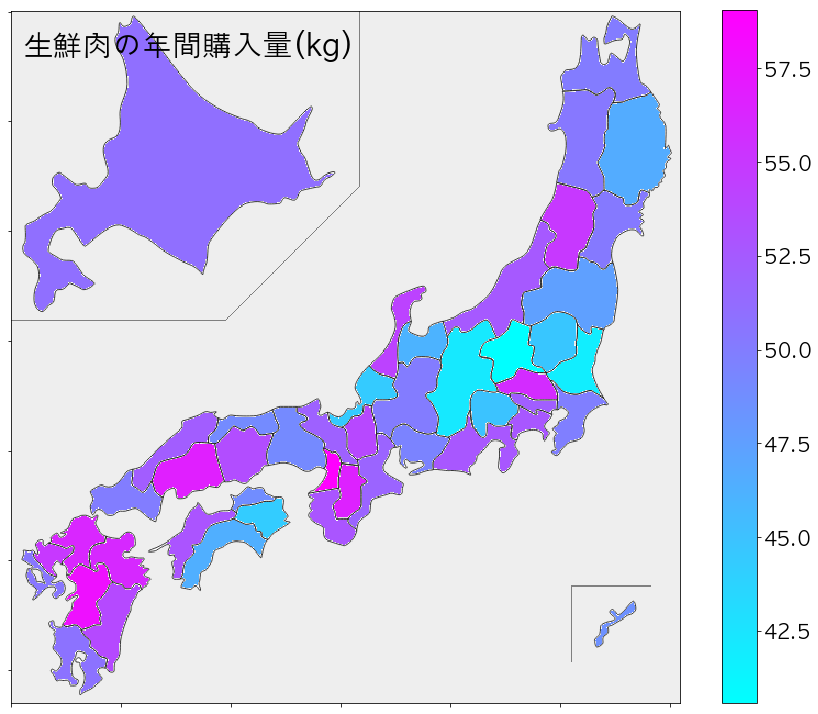

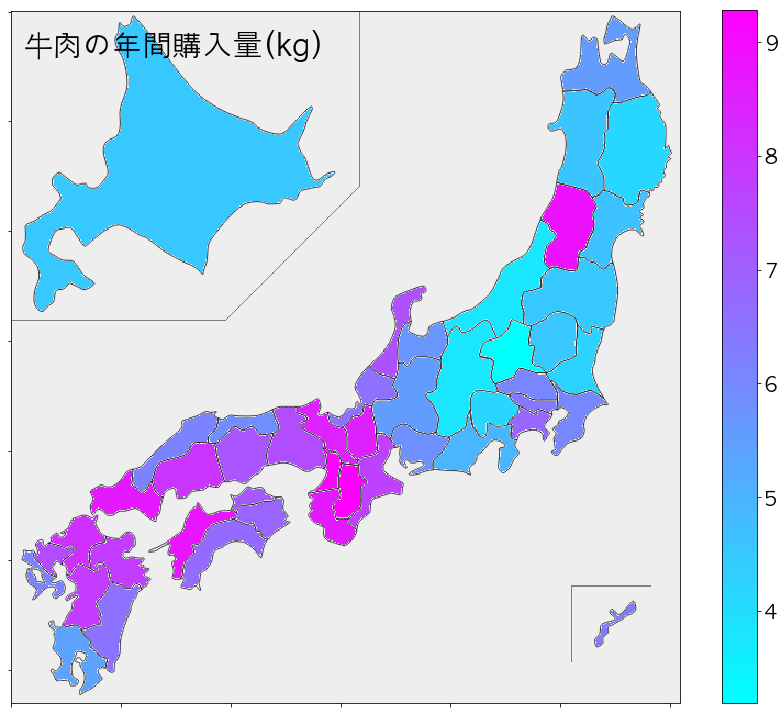

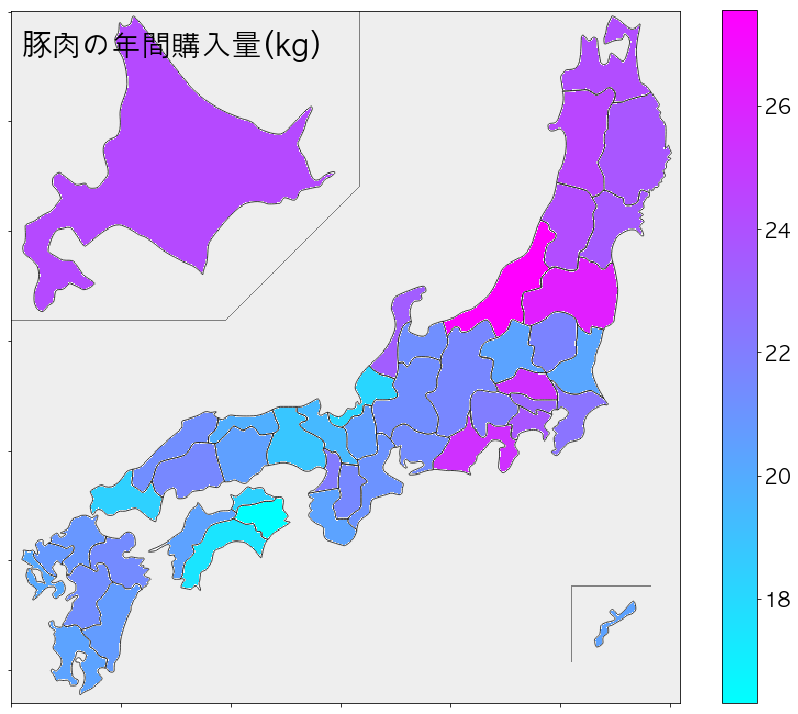

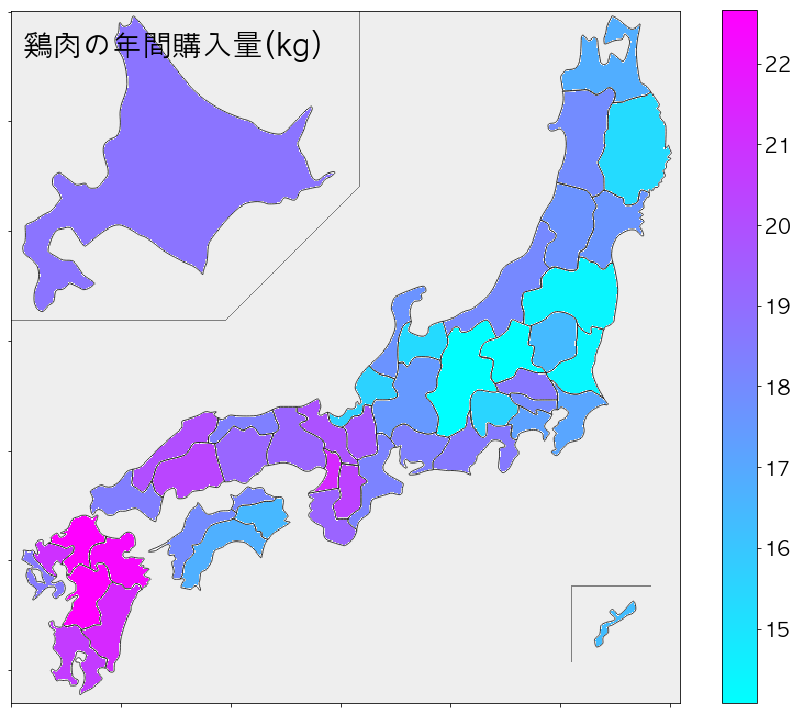

In [68]:
draw_map_from_series(data[2022]['数量']['生鮮肉']/1000,'生鮮肉の年間購入量(kg)',plt.cm.cool)
draw_map_from_series(data[2022]['数量']['牛肉']/1000,'牛肉の年間購入量(kg)',plt.cm.cool)
draw_map_from_series(data[2022]['数量']['豚肉']/1000,'豚肉の年間購入量(kg)',plt.cm.cool)
draw_map_from_series(data[2022]['数量']['鶏肉']/1000,'鷄肉の年間購入量(kg)',plt.cm.cool)

#### (参考)牛 v.s. 豚　の比率を描く

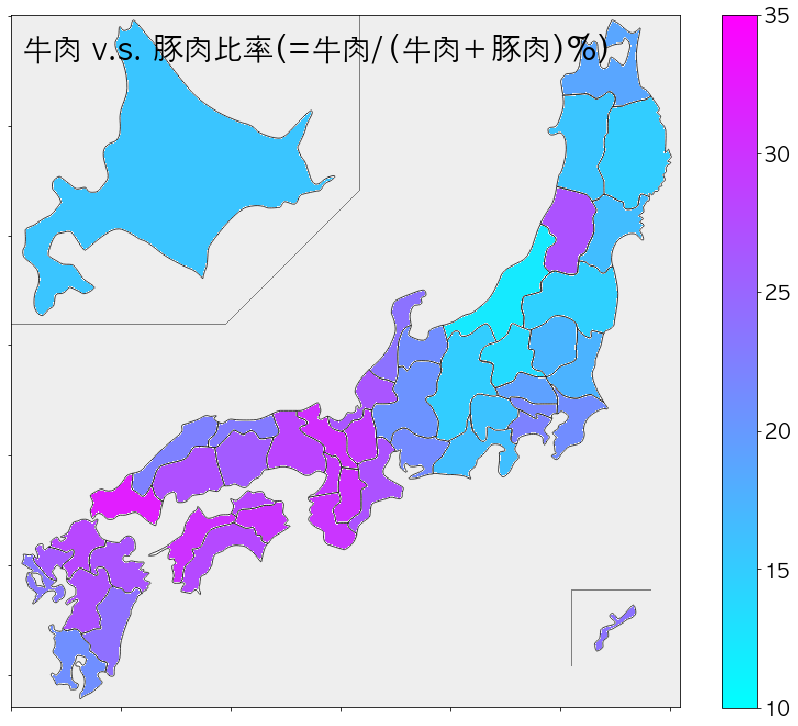

In [70]:
draw_map_from_series(data[2022]['数量']['牛肉']*100/
                     (data[2022]['数量']['牛肉']+data[2022]['数量']['豚肉']),
                     '牛肉 v.s. 豚肉比率(=牛肉/(牛肉＋豚肉)%)',plt.cm.cool,{"min":10,"max":35})

## 大正14年の豚肉食を描く

★畜産彙纂_第24号_全国各都市における主要畜産物の需要供給概況.pdf

In [82]:
pork_1925={ # 匁 ＝3．75ｇ
'北海道':833,
'秋田県':693,
'福島県':656,
'茨城県':1194,
'栃木県':684,
'群馬県':606,
'埼玉県':675,
'千葉県':2749,
'東京都':2398, #(2398+968)/2
'神奈川県':1141, # (1141+831+786)/3
'山梨県':1700,
'長野県':671,
'静岡県':692,
'長崎県':629,
'宮崎県':734,
'沖縄県':1701 #(1701+832)/2
}
pork_1925=pd.Series(pork_1925)

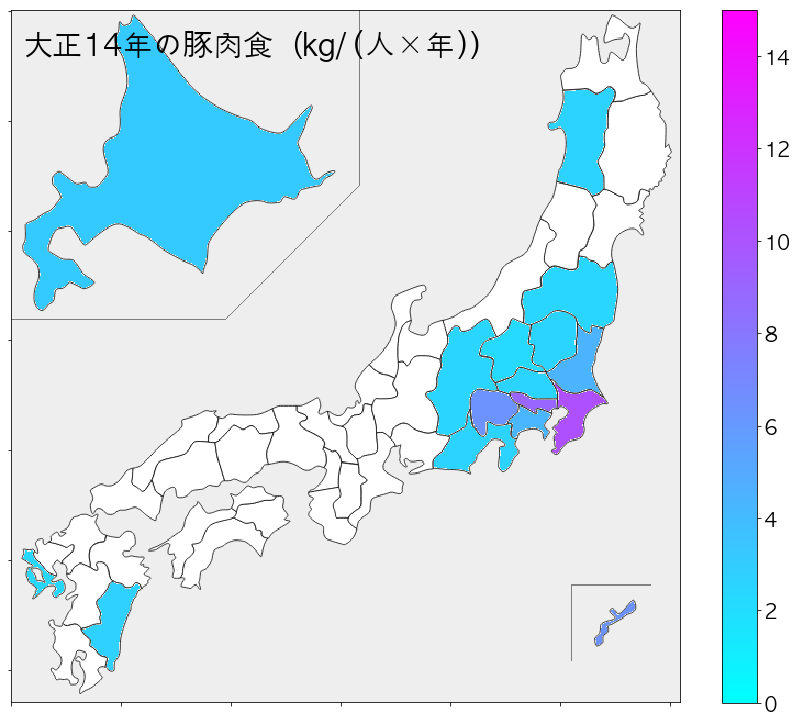

In [116]:
draw_map_from_series(pork_1925*3.75/1000,
                     '大正14年の豚肉食（kg/(人×年)）',plt.cm.cool,
                    {"min":0,"max":15})

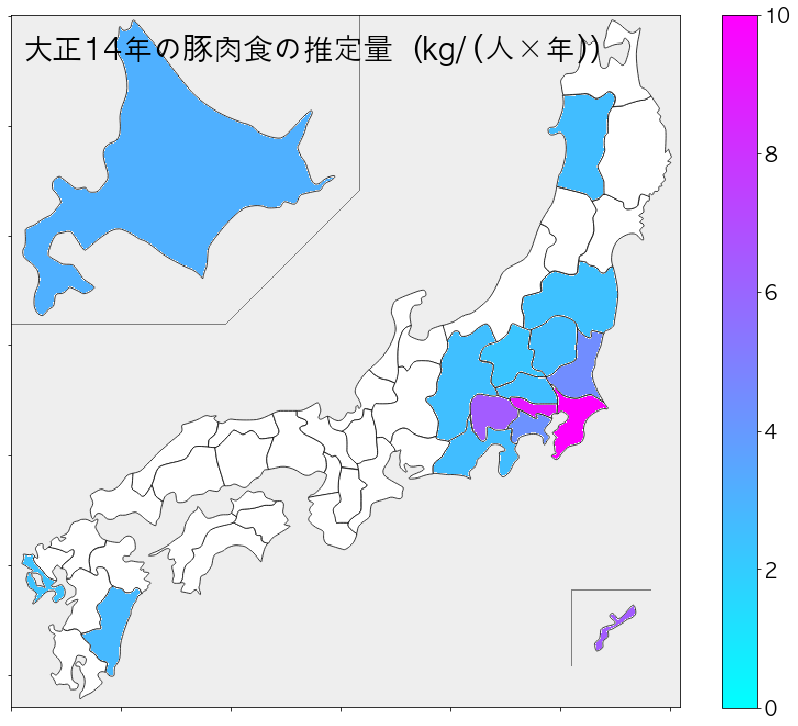

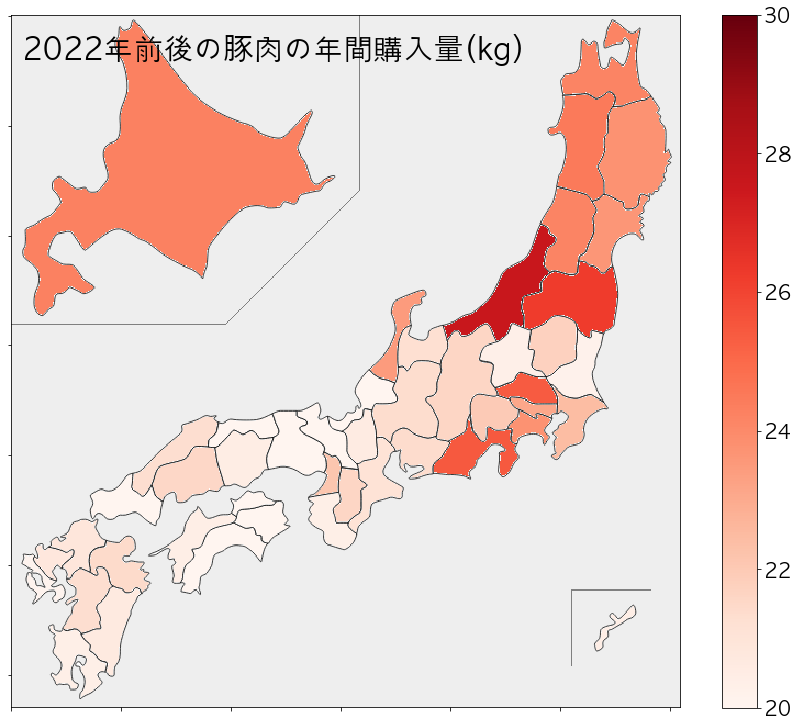

In [112]:
draw_map_from_series(pork_1925*3.75/1000,
                     '大正14年の豚肉食の推定量（kg/(人×年)）',plt.cm.cool,
                    {"min":0,"max":10})
draw_map_from_series(data[2022]['数量']['豚肉']/1000,'2022年前後の豚肉の年間購入量(kg)',plt.cm.Reds,
                    {"min":20,"max":30}
                    )